1. Setup & Import Library

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

2. Load data utama

In [ ]:
app_train = pd.read_csv('/content/drive/MyDrive/RAKAMIN/application_train.csv')
app_test = pd.read_csv('/content/drive/MyDrive/RAKAMIN/application_test.csv')

bureau = pd.read_csv('/content/drive/MyDrive/RAKAMIN/bureau.csv')
prev_app = pd.read_csv('/content/drive/MyDrive/RAKAMIN/previous_application.csv')
inst_pay = pd.read_csv('/content/drive/MyDrive/RAKAMIN/installments_payments.csv')
pos_cash = pd.read_csv('/content/drive/MyDrive/RAKAMIN/POS_CASH_balance.csv')
cc_bal = pd.read_csv('/content/drive/MyDrive/RAKAMIN/credit_card_balance.csv')

print("Train shape:", app_train.shape)
print("Test shape :", app_test.shape)
print(app_train[['SK_ID_CURR','TARGET']].head())

Train shape: (307511, 122)
Test shape : (48744, 121)
   SK_ID_CURR  TARGET
0      100002       1
1      100003       0
2      100004       0
3      100006       0
4      100007       0


3. Preprocessing dasar application_train

In [ ]:
data = app_train.copy()

In [ ]:
#Buat fitur usia dan lama kerja (DAYS_* bernilai negatif, jadi dikali -1)
data['DAYS_BIRTH_POS'] = -data['DAYS_BIRTH']
data['DAYS_EMPLOYED_POS'] = -data['DAYS_EMPLOYED']

data['AGE_YEARS'] = data['DAYS_BIRTH_POS'] / 365.25
data['EMPLOY_YEARS'] = data['DAYS_EMPLOYED_POS'] / 365.25

#Fitur rasio
data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 1e-5)
data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 1e-5)

4. Agregasi sederhana dari bureau

In [ ]:
#Agregasi bureau per pemohon (SK_ID_CURR)
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
'SK_ID_BUREAU':'count', # jumlah kredit sebelumnya
'AMT_CREDIT_SUM_DEBT':'sum', # total debt
'CREDIT_DAY_OVERDUE':'max' # max DPD
}).rename(columns={
'SK_ID_BUREAU':'BUREAU_NUM_CREDITS',
'AMT_CREDIT_SUM_DEBT':'BUREAU_TOTAL_DEBT',
'CREDIT_DAY_OVERDUE':'BUREAU_MAX_DPD'
}).reset_index()

data = data.merge(bureau_agg, on='SK_ID_CURR', how='left')

5. Agregasi sederhana dari previous_application

In [ ]:
#Flag approved
prev_app['IS_APPROVED'] = (prev_app['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)

prev_agg = prev_app.groupby('SK_ID_CURR').agg({
'SK_ID_PREV':'count',
'IS_APPROVED':'mean'
}).rename(columns={
'SK_ID_PREV':'PREV_NUM_APP',
'IS_APPROVED':'PREV_APPROVAL_RATE'
}).reset_index()

data = data.merge(prev_agg, on='SK_ID_CURR', how='left')

6. Agregasi sederhana dari installments_payments

In [ ]:
#Telat bayar: AMT_PAYMENT < AMT_INSTALMENT
inst_pay['IS_LATE'] = (inst_pay['AMT_PAYMENT'] + 1e-5 < inst_pay['AMT_INSTALMENT']).astype(int)

inst_agg = inst_pay.groupby('SK_ID_CURR').agg({
'IS_LATE':'mean'
}).rename(columns={
'IS_LATE':'LATE_PAYMENT_RATE'
}).reset_index()

data = data.merge(inst_agg, on='SK_ID_CURR', how='left')

7. Tangani missing values & pilih fitur

In [ ]:
#Pilih subset fitur yang logis untuk model (bisa kamu tambah sendiri)
num_features = [
    'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
    'AGE_YEARS','EMPLOY_YEARS','CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO',
    'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',   # ← pakai underscore
    'BUREAU_NUM_CREDITS','BUREAU_TOTAL_DEBT','BUREAU_MAX_DPD',
    'PREV_NUM_APP','PREV_APPROVAL_RATE','LATE_PAYMENT_RATE'
]


cat_features = [
'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE','ORGANIZATION_TYPE','REGION_RATING_CLIENT'
]

In [ ]:
print(data.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

In [ ]:
#Isi missing numerik dengan median
for col in num_features:
  data[col] = data[col].fillna(data[col].median())

In [ ]:
#Isi missing kategorik dengan 'Unknown'
for col in cat_features:
  data[col] = data[col].fillna('Unknown')

8. One-hot encoding kategorik

In [ ]:
data_model = data[num_features + cat_features + ['TARGET']].copy()

data_model = pd.get_dummies(data_model, columns=cat_features, drop_first=True)

print("Shape after encoding:", data_model.shape)

X = data_model.drop('TARGET', axis=1)
y = data_model['TARGET']

Shape after encoding: (307511, 103)


9. Train–test split dan scaling

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
#Scaling hanya numerik; one-hot biarkan

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols_in_X = [c for c in X.columns if c in num_features]

X_train_scaled[num_cols_in_X] = scaler.fit_transform(X_train[num_cols_in_X])
X_test_scaled[num_cols_in_X] = scaler.transform(X_test[num_cols_in_X])



10. EDA

In [ ]:
#Default rate keseluruhan

default_rate = y.mean()
print(f"Default rate: {default_rate:.3f}")

Default rate: 0.081



Default rate per income type:
                        TARGET
NAME_INCOME_TYPE              
Maternity leave       0.400000
Unemployed            0.363636
Working               0.095885
Commercial associate  0.074843
State servant         0.057550
Pensioner             0.053864
Businessman           0.000000
Student               0.000000


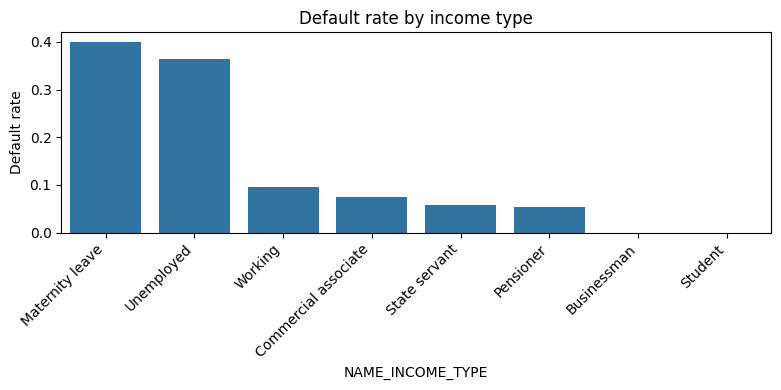

In [ ]:
#Contoh insight: default rate per NAME_INCOME_TYPE

tmp = data[['NAME_INCOME_TYPE','TARGET']].groupby('NAME_INCOME_TYPE').mean().sort_values('TARGET', ascending=False)
print("\nDefault rate per income type:")
print(tmp)

plt.figure(figsize=(8,4))
sns.barplot(x=tmp.index, y=tmp['TARGET'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Default rate')
plt.title('Default rate by income type')
plt.tight_layout()
plt.show()

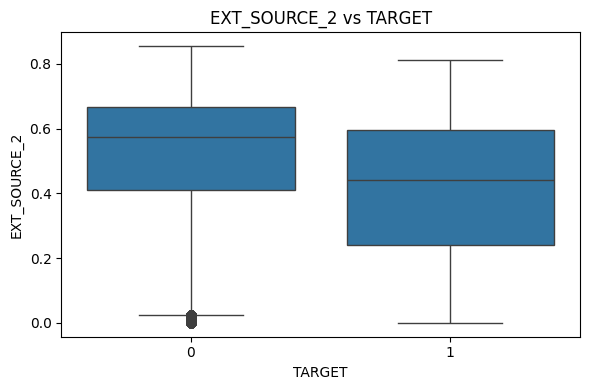

In [ ]:
#Insight lain: hubungan EXT_SOURCE2 dengan TARGET

plt.figure(figsize=(6,4))
sns.boxplot(x='TARGET', y='EXT_SOURCE_2', data=data)  # ← perhatikan nama kolom
plt.title('EXT_SOURCE_2 vs TARGET')
plt.tight_layout()
plt.show()


11. Model 1 – Logistic Regression

In [ ]:
log_reg = LogisticRegression(
max_iter=1000,
class_weight='balanced',
n_jobs=-1
)

log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))

auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"AUC-ROC: {auc_lr:.4f}")

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503

Confusion matrix:
[[39049 17489]
 [ 1600  3365]]
AUC-ROC: 0.7474


12. Model 2 – Random Forest

In [ ]:
rf = RandomForestClassifier(
n_estimators=200,
max_depth=10,
n_jobs=-1,
random_state=42,
class_weight='balanced'
)

rf.fit(X_train, y_train) # RF tidak wajib di-scale

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"AUC-ROC: {auc_rf:.4f}")


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56538
           1       0.17      0.63      0.27      4965

    accuracy                           0.72     61503
   macro avg       0.56      0.68      0.55     61503
weighted avg       0.89      0.72      0.78     61503

Confusion matrix:
[[41022 15516]
 [ 1818  3147]]
AUC-ROC: 0.7429


13. Plot ROC curve (bahan visual model)

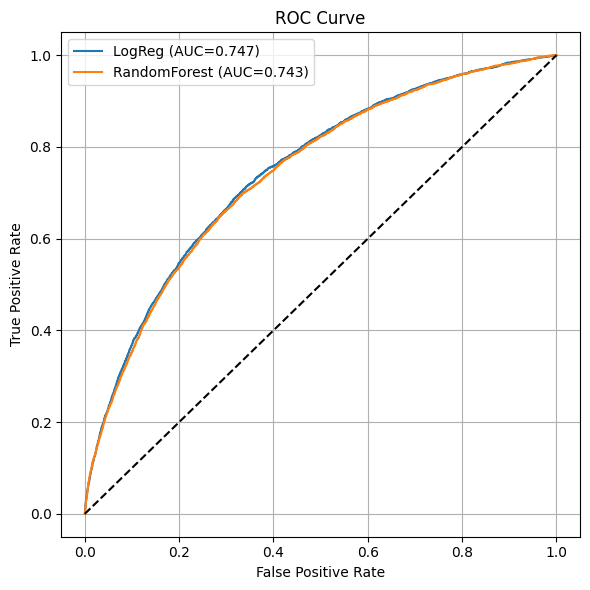

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # garis diagonal referensi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


14. Feature importance Random Forest


Top 20 features (Random Forest):
EXT_SOURCE_3                                         0.205656
EXT_SOURCE_2                                         0.199961
EXT_SOURCE_1                                         0.080633
AGE_YEARS                                            0.052581
EMPLOY_YEARS                                         0.048302
BUREAU_TOTAL_DEBT                                    0.036062
PREV_APPROVAL_RATE                                   0.031425
AMT_GOODS_PRICE                                      0.031229
AMT_CREDIT                                           0.027439
NAME_EDUCATION_TYPE_Higher education                 0.023540
AMT_ANNUITY                                          0.023387
ANNUITY_INCOME_RATIO                                 0.020310
CREDIT_INCOME_RATIO                                  0.020081
CODE_GENDER_M                                        0.019732
LATE_PAYMENT_RATE                                    0.018689
NAME_EDUCATION_TYPE_Secondary / seco

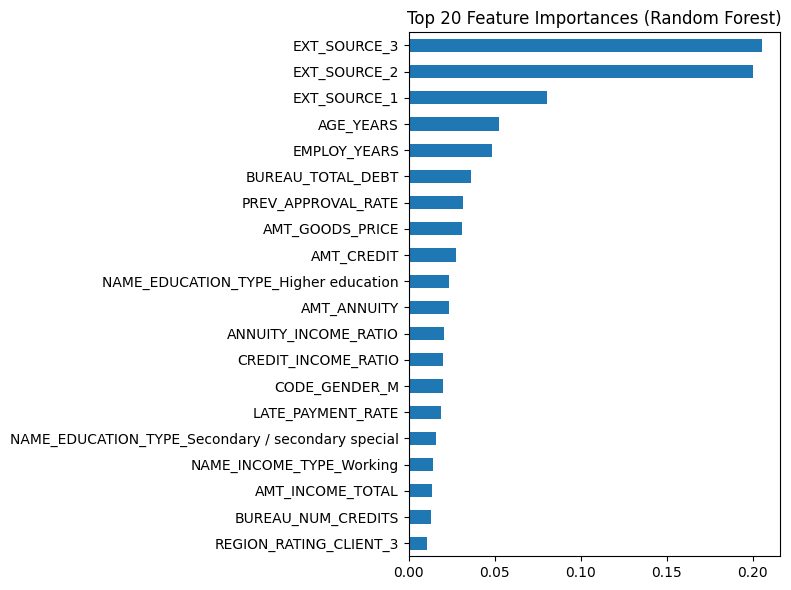

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
imp_top = importances.sort_values(ascending=False).head(20)

print("\nTop 20 features (Random Forest):")
print(imp_top)

plt.figure(figsize=(8,6))
imp_top.sort_values().plot(kind='barh')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

Simpan ke CSV

In [ ]:
imp_top.to_csv('top_features_rf.csv')
tmp.to_csv('default_rate_by_income_type.csv')